# LGBM Train



In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/RecSys2024/'
# 3.6.0以降だとLightGBMTunerが動かない
#!pip3 install optuna==3.5.0
!pip3 install polars lightgbm pyarrow

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 25.4 MB/s eta 0:00:00


In [8]:
#DEBUG_MODE = True
DEBUG_MODE = False
OPTUNA_FLAG = False
TRAIN_FRAC = 1.0 # train dataのnegative sampleをどれくらいsamplingするか
#TRAIN_FRAC = 0.8 # train dataのnegative sampleをどれくらいsamplingするか
#TRAIN_FRAC = 0.5 # train dataのnegative sampleをどれくらいsamplingするか
VALID_FRAC = 0.25 # validatoin dataをどれくらいsamplingするか

train_type = 'train'
#train_type = 'valid' # use validation data as training for final sub

In [9]:
# ==================================================== # Library # ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import polars as pl
import joblib
import pyarrow
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
# optuna
if OPTUNA_FLAG:
    import optuna.integration.lightgbm as lgb
else:
    import lightgbm as lgb
    print(lgb.__version__)

4.3.0


# Reading Input File

In [10]:
out_path = base_path + 'feature_output'
bins = [600, 3600, 3600 * 6]

# Feature Engineering

In [14]:
def read_files(train_type = 'train'):
    if DEBUG_MODE:
        TRAIN_FRAC = 1.0
        VALID_FRAC = 1.0
        impression = pl.read_parquet(f"{out_path}/small_{train_type}_impression.parquet")
        impression_article = pl.read_parquet(f"{out_path}/small_{train_type}_impression_article.parquet")
        user = pl.read_parquet(f"{out_path}/small_{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/small_{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/small_{train_type}_article.parquet")
    else:
        impression = pl.read_parquet(f"{out_path}/{train_type}_impression.parquet")
        impression_article = pl.read_parquet(f"{out_path}/{train_type}_impression_article.parquet")
        user = pl.read_parquet(f"{out_path}/{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/{train_type}_article.parquet")
    return impression_article, impression, user, user_article, article

def add_pop_count(df, out_col_name, bins):

    for bin in bins:
        df = df.with_columns(
            (df["impression_time"] / bin).cast(pl.Int64).alias(f"time_bin_{bin}")
        )
        grouped_df = df.group_by([f"time_bin_{bin}", "article_id_inview"]).agg(
            pl.count().cast(pl.Int32).alias(out_col_name + str(bin))
        )
        df = df.join(
            grouped_df,
            on=[f"time_bin_{bin}", "article_id_inview"],
            how="left"
        )
        df = df.drop(f"time_bin_{bin}")
    return df


def join_features(impression_article, impression, user, user_article, article, bins):
    print('join features....')
    df = impression_article.select("impression_id", "article_id_inview", "clicked").join(impression, on="impression_id", how="inner")
    del impression_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add view_cnt....')
    df = add_pop_count(df,"view_cnt", bins)
    df = reduce_mem_usage(df)

    print('add user features....')
    df = df.join(user, on="user_id", how="left")
    del user
    gc.collect()
    df = reduce_mem_usage(df)

    print('add article features....')
    df = df.rename({
        "article_id_inview": "to_article_id"
    })
    df = df.join(
        article.rename({col: f"to_{col}" for col in article.columns}),
        on="to_article_id",
        how="left"
    )
    del article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add user article features....')
    df = df.join(
        user_article.rename({col: f"to_{col}" for col in user_article.columns if col != 'user_id'}),
        on=["user_id", "to_article_id"],
        how="left"
    )
    df = df.drop(['user_id', 'to_article_id'])
    del user_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('cast features....')
    for bin in bins:
        df = df.with_columns(
            pl.col(f"view_cnt{bin}").fill_null(0).cast(pl.Int32)
        )
    df = reduce_mem_usage(df)
    return df


def generate_unixtime_features(df, unixtime_list):

    for col_name in unixtime_list:
        df = df.with_columns(
            (pl.col("impression_time") - pl.col(col_name)).alias(f"{col_name}_diff").cast(pl.Int64)
        )
        df = df.drop(col_name)
    df = df.drop('impression_time')
    df = reduce_mem_usage(df)
    return df


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data
    #return df_data, cat_cols


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage in Polars.
    """

    # Initialize an empty list to store optimized columns
    optimized_columns = []

    for col in df.columns:
        col_data = df[col]
        col_type = col_data.dtype

        if col_type in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt32]:
            col_data = col_data.fill_null(0)
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                optimized_columns.append(col_data.cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                optimized_columns.append(col_data.cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                optimized_columns.append(col_data.cast(pl.Int32))
            else:
                optimized_columns.append(col_data.cast(pl.Int64))
        elif col_type in [pl.Float32, pl.Float64]:
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                optimized_columns.append(col_data.cast(pl.Float32))
            else:
                optimized_columns.append(col_data.cast(pl.Float64))
        else:
            optimized_columns.append(col_data)
    # Create a new DataFrame with optimized columns
    optimized_df = pl.DataFrame({col: optimized_columns[i] for i, col in enumerate(df.columns)})

    return optimized_df


def cast_float_to_int(df, columns):
    for col in columns:
        df = df.with_columns(pl.col(col).cast(pl.Int64))
    return df


def negative_sampling(df, frac=0.5, seed=42):
    negative_examples = df.filter(pl.col("clicked") == False)
    positive_examples = df.filter(pl.col("clicked") == True)
    reduced_negatives = negative_examples.sample(fraction = frac, seed=seed)

    return pl.concat([reduced_negatives, positive_examples]).sort("impression_id")

In [15]:
valid_impression_article, valid_impression, valid_user, valid_user_article, valid_article = read_files(train_type='valid')
# validはデータ量が多いので半分に削る
valid_impression = valid_impression.sample(fraction=VALID_FRAC, seed=42)

float_int_cols = ['read_time', 'scroll_percentage']
valid_impression = cast_float_to_int(valid_impression, float_int_cols)
valid_impression = reduce_mem_usage(valid_impression)
valid_impression_article = reduce_mem_usage(valid_impression_article)

float_int_cols = ['u_read_time_last', 'u_scroll_percentage_last', 'u_impression_time_mean']
valid_user = cast_float_to_int(valid_user, float_int_cols)
valid_user = reduce_mem_usage(valid_user)

float_int_cols = ['ua_read_time_last', 'ua_scroll_percentage_last']
valid_user_article = cast_float_to_int(valid_user_article, float_int_cols)
valid_user_article = reduce_mem_usage(valid_user_article)

float_int_cols = ['a_total_read_time']
valid_article = cast_float_to_int(valid_article, float_int_cols)
valid_article = reduce_mem_usage(valid_article)

valid = join_features(valid_impression_article, valid_impression, valid_user, valid_user_article, valid_article, bins)
del valid_impression_article, valid_impression, valid_user, valid_user_article, valid_article
gc.collect()

join features....
add view_cnt....
add user features....
add article features....
add user article features....
cast features....


In [ ]:
if train_type == 'train':
    train_impression_article, train_impression, train_user, train_user_article, train_article = read_files(train_type='train')
    # negative sampling
    train_impression_article = negative_sampling(train_impression_article, frac = TRAIN_FRAC)

    # memory節約, intだけどfloatになってるはいったんint64にしてから変換
    float_int_cols = ['read_time', 'scroll_percentage']
    train_impression = cast_float_to_int(train_impression, float_int_cols)
    train_impression = reduce_mem_usage(train_impression)
    train_impression_article = reduce_mem_usage(train_impression_article)

    float_int_cols = ['u_read_time_last', 'u_scroll_percentage_last', 'u_impression_time_mean']
    train_user = cast_float_to_int(train_user, float_int_cols)
    train_user = reduce_mem_usage(train_user)

    float_int_cols = ['ua_read_time_last', 'ua_scroll_percentage_last']
    train_user_article = cast_float_to_int(train_user_article, float_int_cols)
    train_user_article = reduce_mem_usage(train_user_article)

    float_int_cols = ['a_total_read_time']
    train_article = cast_float_to_int(train_article, float_int_cols)
    train_article = reduce_mem_usage(train_article)

    train = join_features(train_impression_article, train_impression, train_user, train_user_article, train_article, bins)
    del train_impression_article, train_impression, train_user, train_user_article, train_article
    gc.collect()
else:
    train = valid

join features....
add view_cnt....
add user features....
add article features....
add user article features....
cast features....


In [ ]:
# unixtimeのfeatureをdiffにする
unixtime_list = ['u_impression_time_last', 'u_impression_time_mean', 'to_ua_impression_time_mean', 'to_ua_impression_time_last', 'to_a_published_time', 'to_a_last_modified_time']
train = generate_unixtime_features(train, unixtime_list)
valid = generate_unixtime_features(valid, unixtime_list)

In [ ]:
print(train.shape)
train.head()

(2585747, 44)


impression_id,clicked,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,to_a_premium,to_a_article_type,to_a_category,to_a_category_str,to_a_total_inviews,to_a_total_pageviews,to_a_total_read_time,to_a_sentiment_score,to_a_sentiment_label,to_a_ner_clusters_first,to_a_entity_groups_first,to_a_topics_first,to_a_subcategory_first,to_ua_scroll_percentage_mean,to_ua_scroll_percentage_last,to_ua_read_time_mean,to_ua_read_time_last,to_ua_count,u_impression_time_last_diff,u_impression_time_mean_diff,to_ua_impression_time_mean_diff,to_ua_impression_time_last_diff,to_a_published_time_diff,to_a_last_modified_time_diff
i32,bool,i16,i8,i8,bool,i8,i8,i8,bool,i32,i8,i16,i16,i16,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,i32,f32,str,str,str,str,i16,f32,i8,f32,i16,i8,i32,i32,i32,i32,i32,i32
149474,false,13,0,2,false,0,0,0,false,759,6,130,872,2397,19,3,21.0,47,52.823528,false,"""article_default""",142,"""sport""",398012,95266,7798825,0.9893,"""Negative""","""Alex Cepedas""","""PER""","""Kendt""",317,null,0,null,0,0,820495,1390118,0,1684914473,5958,-3106869
149474,false,13,0,2,false,0,0,0,false,759,6,135,788,2249,19,3,21.0,47,52.823528,false,"""article_default""",498,"""musik""",455723,143520,9298546,0.9546,"""Negative""","""Ben""","""PROD""","""Kendt""",500,null,0,null,0,0,820495,1390118,0,1684914473,4511,-3106869
149474,false,13,0,2,false,0,0,0,false,759,6,111,795,2206,19,3,21.0,47,52.823528,false,"""article_default""",118,"""nyheder""",373488,74491,4365609,0.9481,"""Negative""","""Bank Norwegian""","""ORG""","""Kriminalitet""",133,null,0,null,0,0,820495,1390118,0,1684914473,5907,-3106869
149474,false,13,0,2,false,0,0,0,false,759,6,126,455,1342,19,3,21.0,47,52.823528,false,"""article_default""",414,"""underholdning""",185367,23275,1158189,0.7485,"""Positive""","""Danmark""","""LOC""","""Kendt""",0,null,0,null,0,0,820495,1390118,0,1684914473,1418,-3106869
149474,false,13,0,2,false,0,0,0,false,759,6,125,345,1361,19,3,21.0,47,52.823528,false,"""article_default""",142,"""sport""",220247,22415,1004828,0.9654,"""Negative""","""Giro d""","""EVENT""","""Kendt""",317,null,0,null,0,0,820495,1390118,0,1684914473,1308,-3106869


In [ ]:
train.select('clicked').mean()

clicked
f64
0.090404


In [ ]:
print(valid.shape)
valid.head()

(734213, 44)


impression_id,clicked,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,to_a_premium,to_a_article_type,to_a_category,to_a_category_str,to_a_total_inviews,to_a_total_pageviews,to_a_total_read_time,to_a_sentiment_score,to_a_sentiment_label,to_a_ner_clusters_first,to_a_entity_groups_first,to_a_topics_first,to_a_subcategory_first,to_ua_scroll_percentage_mean,to_ua_scroll_percentage_last,to_ua_read_time_mean,to_ua_read_time_last,to_ua_count,u_impression_time_last_diff,u_impression_time_mean_diff,to_ua_impression_time_mean_diff,to_ua_impression_time_last_diff,to_a_published_time_diff,to_a_last_modified_time_diff
i32,bool,i16,i8,i8,bool,i8,i8,i8,bool,i32,i8,i8,i16,i16,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,i32,f32,str,str,str,str,i16,f32,i8,f32,i16,i8,i32,i32,i32,i32,i32,i32
96798,false,46,0,2,false,0,0,0,false,143,25,18,122,477,130,56,35.238461,95,47.073769,false,"""article_default""",512,"""nationen""",894710,177869,16980028,0.9475,"""Negative""","""Lenovo""","""ORG""","""Erhverv""",0,null,0,null,0,0,258395,1088148,0,1685248308,27844,-2773038
96798,false,46,0,2,false,0,0,0,false,143,25,10,101,434,130,56,35.238461,95,47.073769,false,"""article_default""",498,"""musik""",614501,104504,6765540,0.9793,"""Negative""","""ABBA""","""PROD""","""Kendt""",504,null,0,null,0,0,258395,1088148,0,1685248308,25216,-2773039
96798,false,46,0,2,false,0,0,0,false,143,25,10,82,340,130,56,35.238461,95,47.073769,false,"""article_default""",118,"""nyheder""",758230,96829,9196233,0.6307,"""Negative""","""Altinget""","""ORG""","""Kendt""",128,null,0,null,0,0,258395,1088148,0,1685248308,1908,-2773038
96798,false,46,0,2,false,0,0,0,false,143,25,5,41,179,130,56,35.238461,95,47.073769,false,"""article_native""",539,"""ferie""",4032918,42120,3095533,0.7956,"""Neutral""","""BorderShop""","""LOC""","""Kultur""",0,null,0,null,0,0,258395,1088148,0,1685248308,3509268,-9622479
96798,false,46,0,2,false,0,0,0,false,143,25,5,20,83,130,56,35.238461,95,47.073769,false,"""article_default""",118,"""nyheder""",542568,65461,4174894,0.6931,"""Neutral""","""Florida Atlantic University""","""ORG""","""Dyr""",138,null,0,null,0,0,258395,1088148,0,1685248308,39315,-2773038


In [ ]:
valid.select('clicked').mean()

clicked
f64
0.08365


## Preprocess

In [ ]:
train = to_pandas(train)
valid = to_pandas(valid)

In [ ]:
train_x = train.drop(['clicked'], axis=1)
train_y = train['clicked']
del train
gc.collect()
valid_x = valid.drop(['clicked'], axis=1)
valid_y = valid['clicked']
del valid
gc.collect()

0

In [ ]:
query_list_train = train_x['impression_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid_x['impression_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [ ]:
query_list_train

impression_id
149474        6
150528        9
153068        7
153070        8
153071        9
             ..
580099643    19
580099644    18
580099645     8
580100695     7
580100697     8
Name: count, Length: 232887, dtype: int64

In [ ]:
train_x.head()

,impression_id,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,to_a_premium,to_a_article_type,to_a_category,to_a_category_str,to_a_total_inviews,to_a_total_pageviews,to_a_total_read_time,to_a_sentiment_score,to_a_sentiment_label,to_a_ner_clusters_first,to_a_entity_groups_first,to_a_topics_first,to_a_subcategory_first,to_ua_scroll_percentage_mean,to_ua_scroll_percentage_last,to_ua_read_time_mean,to_ua_read_time_last,to_ua_count,u_impression_time_last_diff,u_impression_time_mean_diff,to_ua_impression_time_mean_diff,to_ua_impression_time_last_diff,to_a_published_time_diff,to_a_last_modified_time_diff
0,149474,13,0,2,False,0,0,0,False,759,6,130,872,2397,19,3,21.0,47,52.823528,False,article_default,142,sport,398012,95266,7798825,0.9893,Negative,Alex Cepedas,PER,Kendt,317,NaN,0,NaN,0,0,820495,1390118,0,1684914473,5958,-3106869
1,149474,13,0,2,False,0,0,0,False,759,6,135,788,2249,19,3,21.0,47,52.823528,False,article_default,498,musik,455723,143520,9298546,0.9546,Negative,Ben,PROD,Kendt,500,NaN,0,NaN,0,0,820495,1390118,0,1684914473,4511,-3106869
2,149474,13,0,2,False,0,0,0,False,759,6,111,795,2206,19,3,21.0,47,52.823528,False,article_default,118,nyheder,373488,74491,4365609,0.9481,Negative,Bank Norwegian,ORG,Kriminalitet,133,NaN,0,NaN,0,0,820495,1390118,0,1684914473,5907,-3106869
3,149474,13,0,2,False,0,0,0,False,759,6,126,455,1342,19,3,21.0,47,52.823528,False,article_default,414,underholdning,185367,23275,1158189,0.7485,Positive,Danmark,LOC,Kendt,0,NaN,0,NaN,0,0,820495,1390118,0,1684914473,1418,-3106869
4,149474,13,0,2,False,0,0,0,False,759,6,125,345,1361,19,3,21.0,47,52.823528,False,article_default,142,sport,220247,22415,1004828,0.9654,Negative,Giro d,EVENT,Kendt,317,NaN,0,NaN,0,0,820495,1390118,0,1684914473,1308,-3106869


In [ ]:
train_x.dtypes

impression_id                         int32
read_time                             int16
scroll_percentage                      int8
device_type                            int8
is_sso_user                            bool
gender                                 int8
postcode                               int8
age                                    int8
is_subscriber                          bool
session_id                            int32
view_num                               int8
view_cnt600                           int16
view_cnt3600                          int16
view_cnt21600                         int16
u_history_len                         int16
u_read_time_last                      int16
u_read_time_mean                    float32
u_scroll_percentage_last               int8
u_scroll_percentage_mean            float32
to_a_premium                           bool
to_a_article_type                  category
to_a_category                         int16
to_a_category_str               

## Training

In [ ]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'ndcg_eval_at': [5, 10],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'verbose': -1,
}

num_round = 300
if train_type == 'valid':
    num_round = 71
verbose_eval = 10
IGNORE_COL_ID = ["impression_id", "session_id"] # inviewはto, article_idはfrom

In [ ]:
print('remove id from features....')
train_x, valid_x = train_x.drop(IGNORE_COL_ID, axis=1), valid_x.drop(IGNORE_COL_ID, axis=1)

remove id from features....


In [ ]:
# 0.62, 0.65を目標
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

#del train_x, train_y
gc.collect()
model = lgb.train(params = params,
    train_set = lgb_train,
    num_boost_round = num_round,
    valid_sets=[lgb_train, lgb_eval],
    #valid_sets=[lgb_train, lgb_train],
    callbacks=[lgb.early_stopping(stopping_rounds=20,  verbose=True),  lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
)
# save model

model_path = base_path + 'models'
if DEBUG_MODE:
    joblib.dump(model, f'{model_path}/small_lgbm_{train_type}_frac{TRAIN_FRAC}.pkl')
else:
    joblib.dump(model, f'{model_path}/lgbm_{train_type}_frac{TRAIN_FRAC}.pkl')

Training until validation scores don't improve for 20 rounds
[10]	training's ndcg@5: 0.645502	training's ndcg@10: 0.673724	valid_1's ndcg@5: 0.509147	valid_1's ndcg@10: 0.558211
[20]	training's ndcg@5: 0.657972	training's ndcg@10: 0.683992	valid_1's ndcg@5: 0.527231	valid_1's ndcg@10: 0.572847
[30]	training's ndcg@5: 0.661992	training's ndcg@10: 0.687174	valid_1's ndcg@5: 0.52946	valid_1's ndcg@10: 0.574594
[40]	training's ndcg@5: 0.665553	training's ndcg@10: 0.690236	valid_1's ndcg@5: 0.528616	valid_1's ndcg@10: 0.57417
Early stopping, best iteration is:
[29]	training's ndcg@5: 0.66201	training's ndcg@10: 0.687167	valid_1's ndcg@5: 0.529743	valid_1's ndcg@10: 0.574613


In [ ]:
model.best_iteration

29

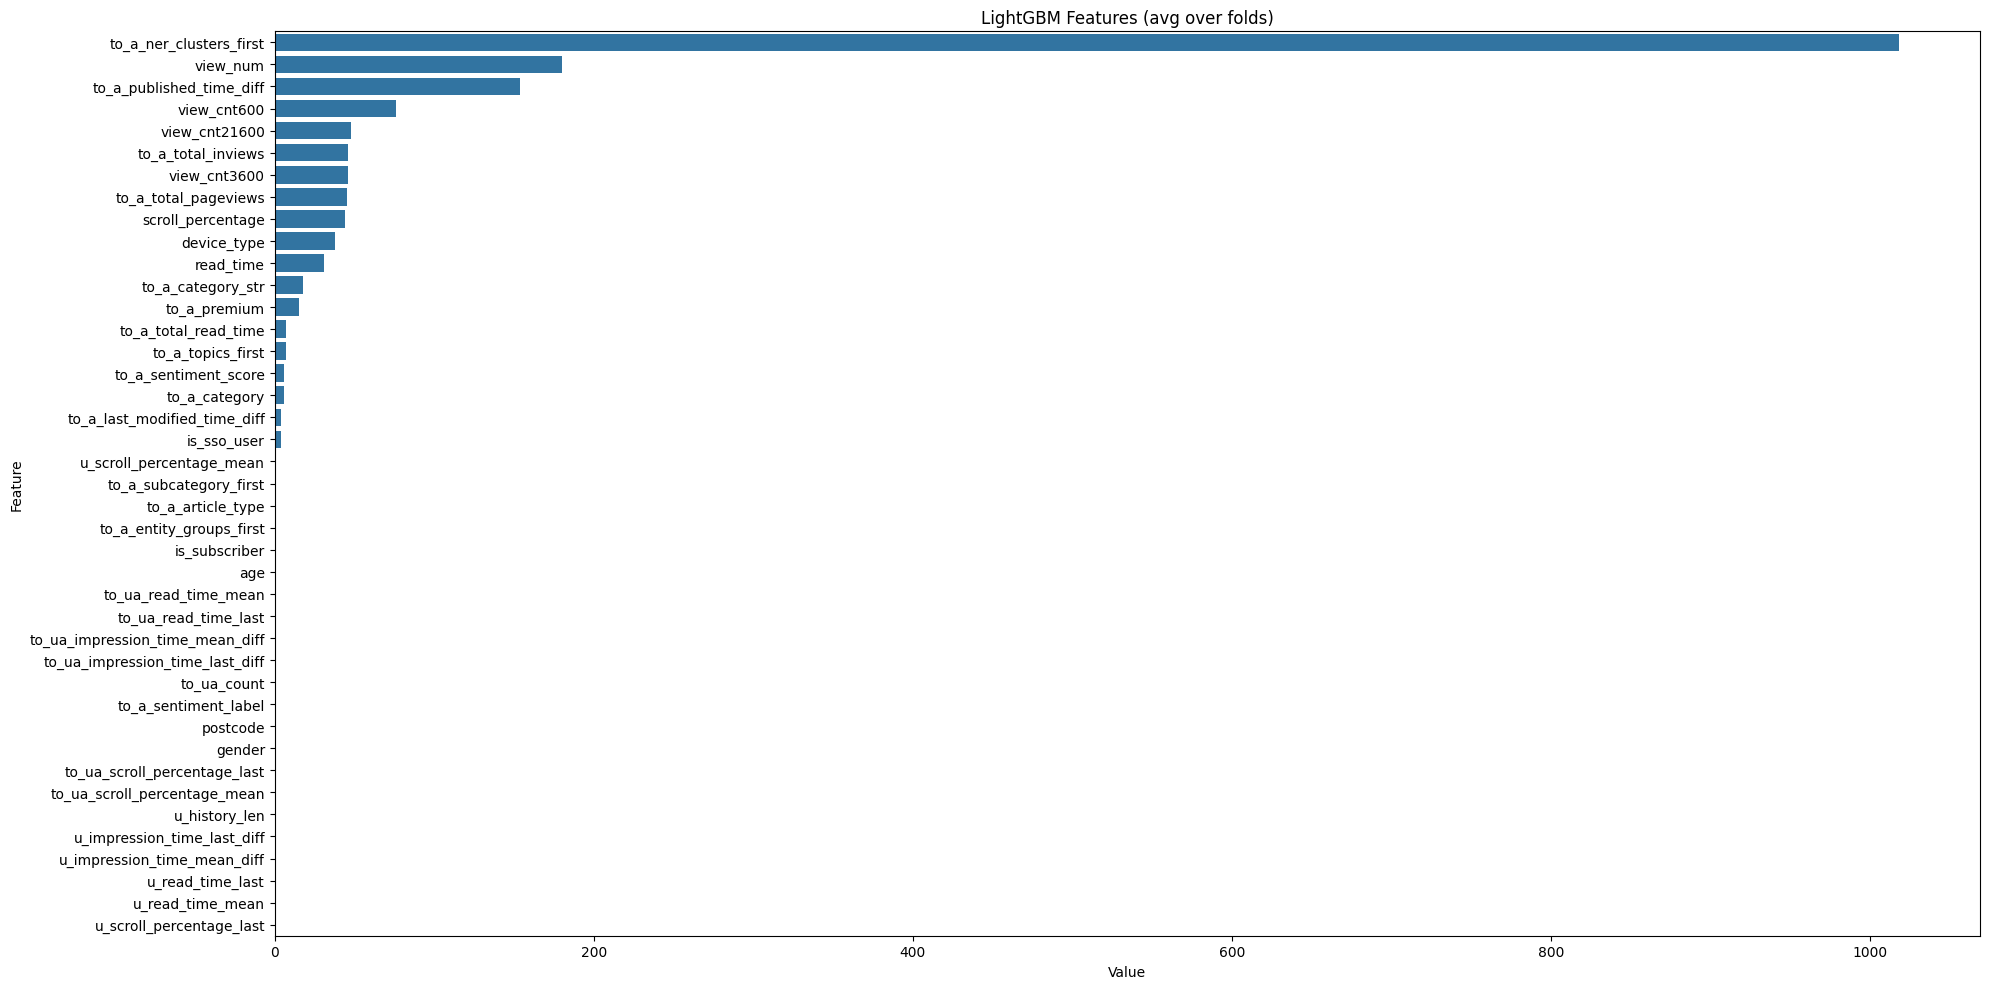

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp_split = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

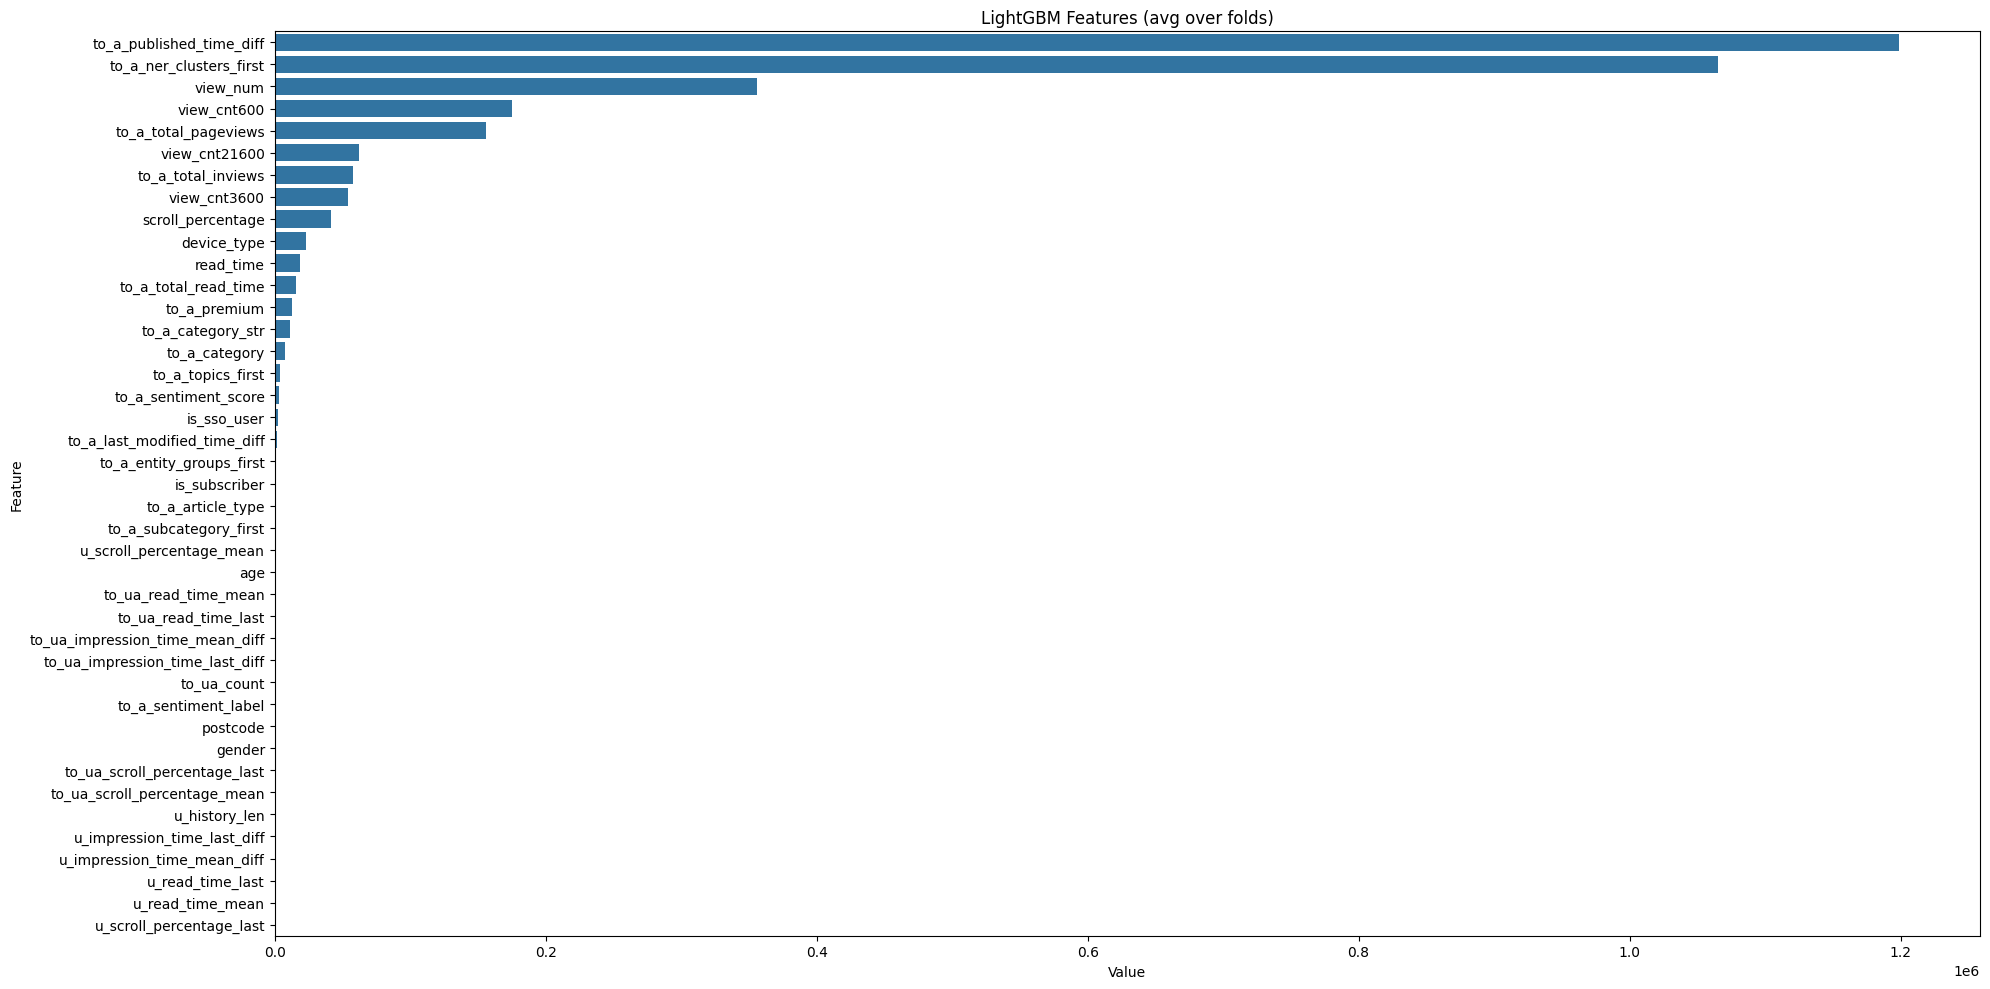

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
# small data
# [68] training's ndcg@5: 0.68384	training's ndcg@10: 0.708506	valid_1's ndcg@5: 0.550625	valid_1's ndcg@10: 0.59301
# 90% negatie sampling [96]	training's ndcg@5: 0.70648	training's ndcg@10: 0.727916	valid_1's ndcg@5: 0.55037	valid_1's ndcg@10: 0.592454
# 80% [84] training's ndcg@5: 0.724863	training's ndcg@10: 0.743467	valid_1's ndcg@5: 0.546675	valid_1's ndcg@10: 0.589225
# 50% [48] training's ndcg@5: 0.791471	training's ndcg@10: 0.801367	valid_1's ndcg@5: 0.549047	valid_1's ndcg@10: 0.590969
# full data
# full, valid_frac=0.5 [72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.554916	valid_1's ndcg@10: 0.596697
#	full, valid_frac=0.25	[72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.555081	valid_1's ndcg@10: 0.596856 -> 0.25で問題なさそう
# under sampling: 0.8 [84]	training's ndcg@5: 0.718681	training's ndcg@10: 0.737356	valid_1's ndcg@5: 0.554494	valid_1's ndcg@10: 0.596234 -> いったんこれでいく
# under sampling: 0.5 [85]	training's ndcg@5: 0.791716	training's ndcg@10: 0.801159	valid_1's ndcg@5: 0.549173	valid_1's ndcg@10: 0.591309

# testに含まれないfeatureを使っていたので修正、featureの数40個ちょっと + bugちょっと修正
# small data
# [179]	training's ndcg@5: 0.727879	training's ndcg@10: 0.743617	valid_1's ndcg@5: 0.542041	valid_1's ndcg@10: 0.583972
# full data
# [71] valid_frac=0.25	training's ndcg@5: 0.666762	training's ndcg@10: 0.689943	valid_1's ndcg@5: 0.537423	valid_1's ndcg@10: 0.580449
# validで学習, [71]	training's ndcg@5: 0.649776	training's ndcg@10: 0.676771	valid_1's ndcg@5: 0.649776	valid_1's ndcg@10: 0.676771